In [1]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import torch
from torchvision import models, transforms
import timm
from PIL import Image

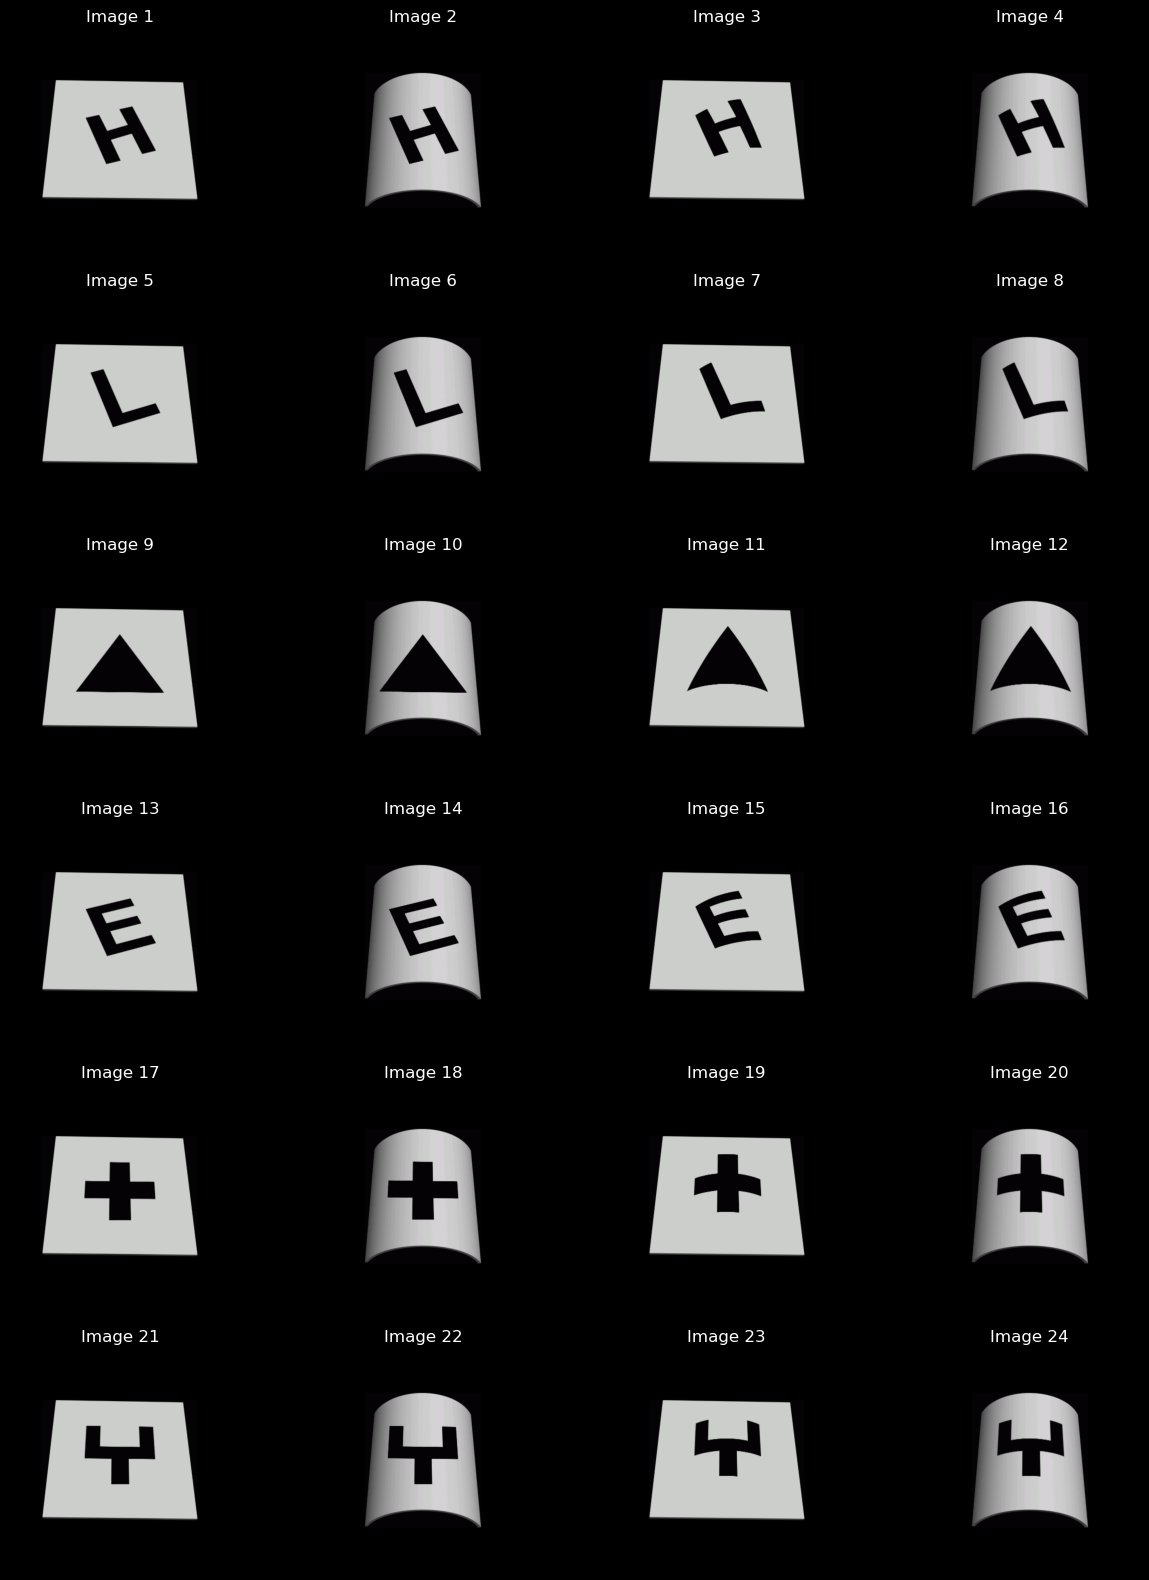

In [17]:
# load stimuli
stimuli = loadmat('rsurf.mat')['stim']
desirable_index = [
    1, 2, 3, 4,
    14, 15, 16, 17,
    27, 28, 29, 30,
    40, 41, 42, 43,
    53, 54, 55, 56,
    66, 67, 68, 69,
]
stimuli = np.array([stimuli[i-1] for i in desirable_index])

# display the stimuli
fig, ax = plt.subplots(6, 4, figsize=(15, 20))
for i, img_arr in enumerate(stimuli):
    ax[i//4, i%4].imshow(img_arr[0], cmap='gray')
    ax[i//4, i%4].axis('off')
    ax[i//4, i%4].set_title(f'Image {i+1}')
plt.show()

In [18]:
print(stimuli.shape)
print(stimuli[0].shape)
print(stimuli[0][0].shape)

(24, 1)
(1,)
(400, 400, 3)


In [19]:
def calcualteSurfaceInvarianceIndex(img1a, img1b, img2a, img2b):
    img1a = img1a.view(img1a.size(0), -1)
    img1b = img1b.view(img1b.size(0), -1)
    img2a = img2a.view(img2a.size(0), -1)
    img2b = img2b.view(img2b.size(0), -1)
    d_1 = torch.norm(img1b - img1a, dim=None)
    d_2 = torch.norm(img2b - img2a, dim=None)
    surface_invariance_index = (d_1 - d_2) / (d_1 + d_2)
    return surface_invariance_index

# VGG16

In [20]:
vgg16 = models.vgg16(pretrained=True)
vgg16.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16.to(device)

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

vgg16_embeddings = []
num_images = stimuli.shape[0]
vgg16Features = vgg16.features
vgg16AvgPool = vgg16.avgpool
vgg16Linear = vgg16.classifier
for i in range(num_images // 4):
    vgg16_embeddings.append([])
    img1a = Image.fromarray(stimuli[i*4 + 2][0])
    img1b = Image.fromarray(stimuli[i*4 + 1][0])
    img2a = Image.fromarray(stimuli[i*4][0])
    img2b = Image.fromarray(stimuli[i*4 + 3][0])
    if img1a.mode != 'RGB':
        img1a = img1a.convert('RGB')
        img1b = img1b.convert('RGB')
        img2a = img2a.convert('RGB')
        img2b = img2b.convert('RGB')
    img1a = preprocess(img1a).unsqueeze(0).to(device)
    img1b = preprocess(img1b).unsqueeze(0).to(device)
    img2a = preprocess(img2a).unsqueeze(0).to(device)
    img2b = preprocess(img2b).unsqueeze(0).to(device)

    with torch.no_grad():
        for layer in vgg16Features:
            img1a = layer(img1a)
            img1b = layer(img1b)
            img2a = layer(img2a)
            img2b = layer(img2b)

            if isinstance(layer, torch.nn.Conv2d):
                vgg16_embeddings[-1].append(calcualteSurfaceInvarianceIndex(img1a, img1b, img2a, img2b))

        img1a = torch.flatten(vgg16AvgPool(img1a))
        img1b = torch.flatten(vgg16AvgPool(img1b))
        img2a = torch.flatten(vgg16AvgPool(img2a))
        img2b = torch.flatten(vgg16AvgPool(img2b))


        for layer in vgg16Linear:
            img1a = layer(img1a)
            img1b = layer(img1b)
            img2a = layer(img2a)
            img2b = layer(img2b)

            if isinstance(layer, torch.nn.Linear):
                vgg16_embeddings[-1].append(calcualteSurfaceInvarianceIndex(img1a, img1b, img2a, img2b))

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


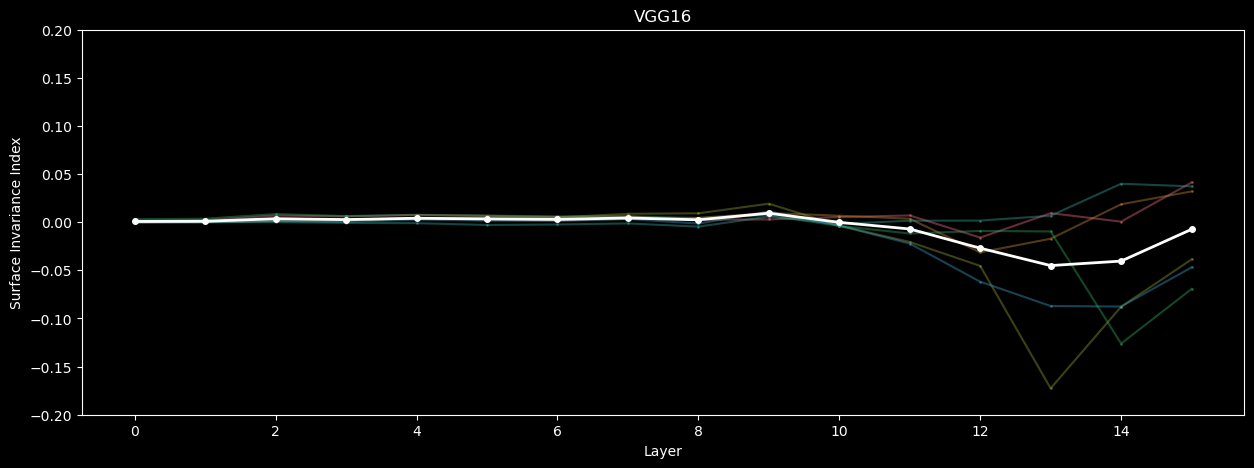

In [35]:
np_vgg16_embeddings = [[e.item() for e in img] for img in vgg16_embeddings]
np_vgg16_mean = np.mean(np_vgg16_embeddings, axis=0)
plt.figure(figsize=(15, 5))
for i in range(num_images // 4):
    color = sns.color_palette("husl", 8)[i % 8] + (0.4,)
    plt.plot(np_vgg16_embeddings[i], color=color, marker='o', markersize=1)
plt.plot(np_vgg16_mean, color='white', marker='o', markersize=4, linewidth=2)
plt.ylim(-0.2, 0.2)
plt.xlabel('Layer')
plt.ylabel('Surface Invariance Index')
plt.title('VGG16')
plt.show()

In [27]:
rand_vgg16 = models.vgg16(pretrained=False)
rand_vgg16.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rand_vgg16.to(device)

rand_vgg16_embeddings = []
num_images = stimuli.shape[0]
rand_vgg16Features = rand_vgg16.features
rand_vgg16AvgPool = rand_vgg16.avgpool
rand_vgg16Linear = rand_vgg16.classifier

for i in range(num_images // 4):
    rand_vgg16_embeddings.append([])
    img1a = Image.fromarray(stimuli[i*4 + 2][0])
    img1b = Image.fromarray(stimuli[i*4 + 1][0])
    img2a = Image.fromarray(stimuli[i*4][0])
    img2b = Image.fromarray(stimuli[i*4 + 3][0])
    if img1a.mode != 'RGB':
        img1a = img1a.convert('RGB')
        img1b = img1b.convert('RGB')
        img2a = img2a.convert('RGB')
        img2b = img2b.convert('RGB')
    img1a = preprocess(img1a).unsqueeze(0).to(device)
    img1b = preprocess(img1b).unsqueeze(0).to(device)
    img2a = preprocess(img2a).unsqueeze(0).to(device)
    img2b = preprocess(img2b).unsqueeze(0).to(device)

    with torch.no_grad():
        for layer in rand_vgg16Features:
            img1a = layer(img1a)
            img1b = layer(img1b)
            img2a = layer(img2a)
            img2b = layer(img2b)

            if isinstance(layer, torch.nn.Conv2d):
                rand_vgg16_embeddings[-1].append(calcualteSurfaceInvarianceIndex(img1a, img1b, img2a, img2b))

        img1a = torch.flatten(rand_vgg16AvgPool(img1a))
        img1b = torch.flatten(rand_vgg16AvgPool(img1b))
        img2a = torch.flatten(rand_vgg16AvgPool(img2a))
        img2b = torch.flatten(rand_vgg16AvgPool(img2b))

        for layer in rand_vgg16Linear:
            img1a = layer(img1a)
            img1b = layer(img1b)
            img2a = layer(img2a)
            img2b = layer(img2b)

            if isinstance(layer, torch.nn.Linear):
                rand_vgg16_embeddings[-1].append(calcualteSurfaceInvarianceIndex(img1a, img1b, img2a, img2b))

c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\ProgramData\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


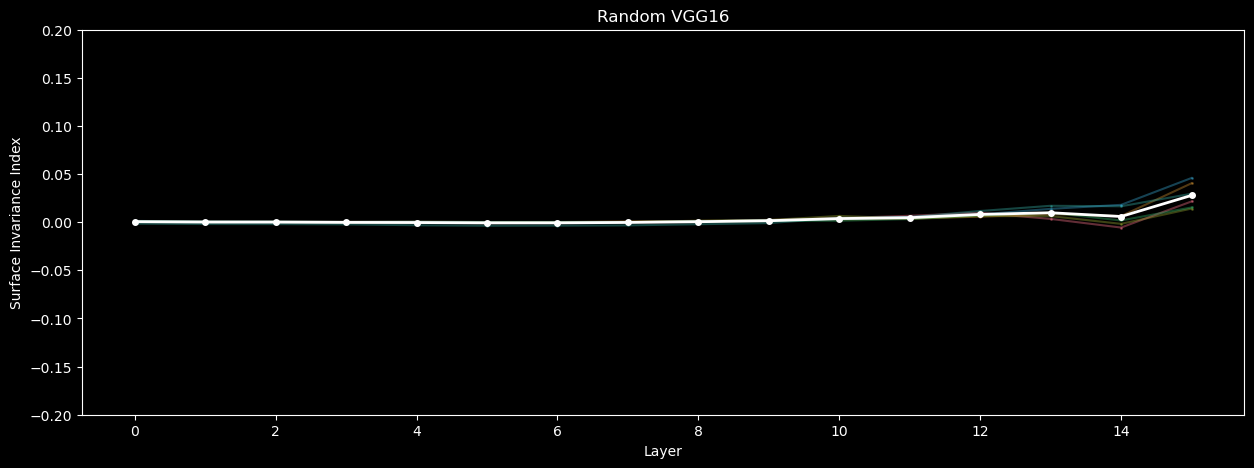

In [36]:
np_rand_vgg16_embeddings = [[e.item() for e in img] for img in rand_vgg16_embeddings]
np_rand_vgg16_mean = np.mean(np_rand_vgg16_embeddings, axis=0)
plt.figure(figsize=(15, 5))
for i in range(num_images // 4):
    color = sns.color_palette("husl", 8)[i % 8] + (0.4,)
    plt.plot(np_rand_vgg16_embeddings[i], color=color, marker='o', markersize=1)
plt.plot(np_rand_vgg16_mean, color='white', marker='o', markersize=4, linewidth=2)
plt.ylim(-0.2, 0.2)
plt.xlabel('Layer')
plt.ylabel('Surface Invariance Index')
plt.title('Random VGG16')
plt.show()

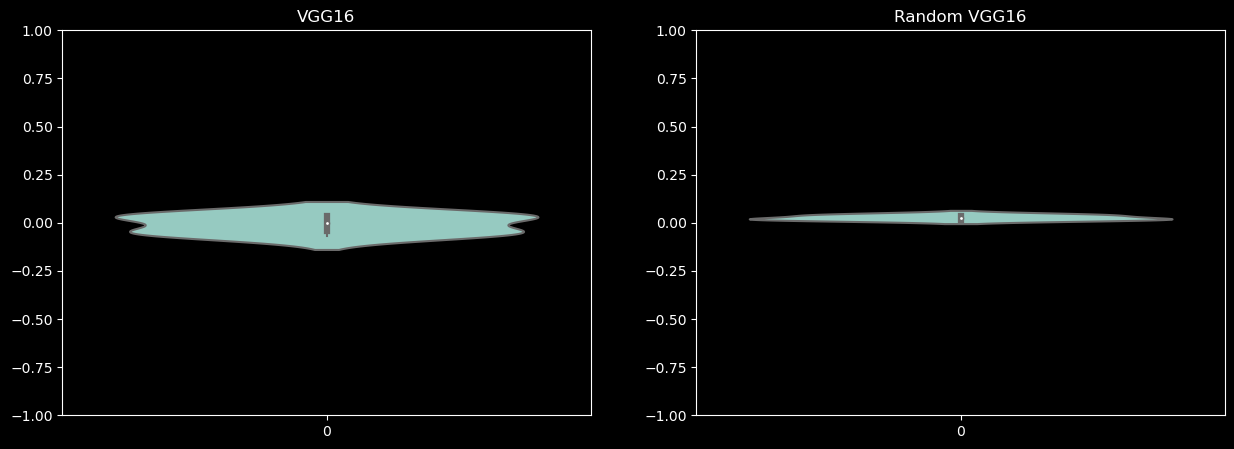

In [34]:
np_vgg16_final_layer = [e[-1] for e in np_vgg16_embeddings]
np_rand_vgg16_final_layer = [e[-1] for e in np_rand_vgg16_embeddings]

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.violinplot(np_vgg16_final_layer, ax=ax[0])
ax[0].set_title('VGG16')
ax[0].set_ylim(-1, 1)
sns.violinplot(np_rand_vgg16_final_layer, ax=ax[1])
ax[1].set_title('Random VGG16')
ax[1].set_ylim(-1, 1)
plt.show()

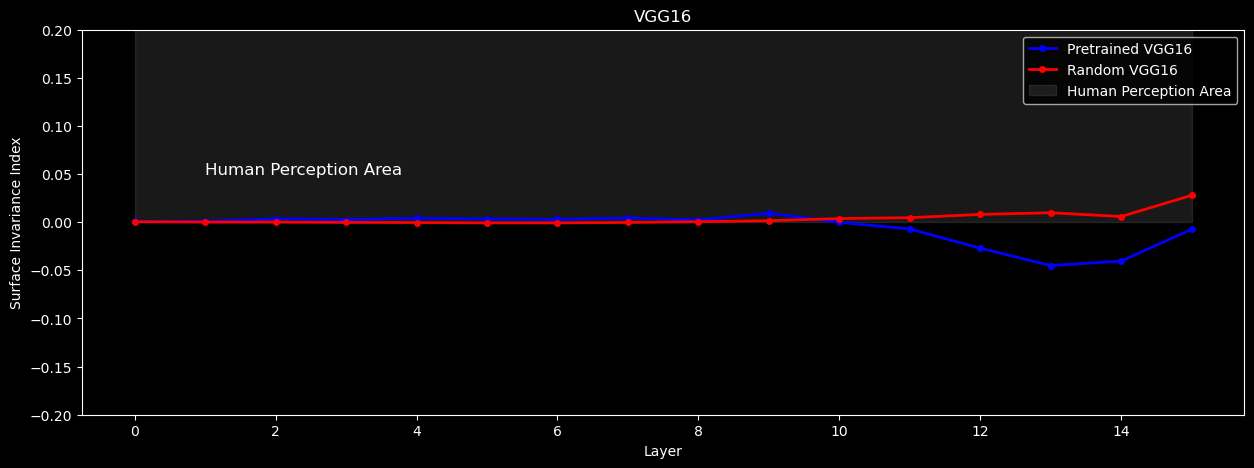

In [39]:
# pretrained vs random
plt.figure(figsize=(15, 5))
plt.plot(np_vgg16_mean, color='blue', marker='o', markersize=4, linewidth=2)
plt.plot(np_rand_vgg16_mean, color='red', marker='o', markersize=4, linewidth=2)
# shade the region y > 0 as human perception area
plt.fill_between(range(len(np_vgg16_mean)), 0, 1, color='gray', alpha=0.2)
plt.text(1, 0.05, 'Human Perception Area', fontsize=12)
plt.ylim(-0.2, 0.2)
plt.xlabel('Layer')
plt.ylabel('Surface Invariance Index')
plt.title('VGG16')
plt.legend(['Pretrained VGG16', 'Random VGG16', 'Human Perception Area'])
plt.show()

In [40]:
print('VGG16')
print('Mean:', np.mean(np_vgg16_final_layer))
print('Std:', np.std(np_vgg16_final_layer))
print('Min:', np.min(np_vgg16_final_layer))
print('Max:', np.max(np_vgg16_final_layer))

print()

print('Random VGG16')
print('Mean:', np.mean(np_rand_vgg16_final_layer))
print('Std:', np.std(np_rand_vgg16_final_layer))
print('Min:', np.min(np_rand_vgg16_final_layer))
print('Max:', np.max(np_rand_vgg16_final_layer))

VGG16
Mean: -0.007392723113298416
Std: 0.045257070395183424
Min: -0.06934453547000885
Max: 0.04129120707511902

Random VGG16
Mean: 0.027872102955977123
Std: 0.01206509406613123
Min: 0.014181377366185188
Max: 0.045980434864759445


# Inception

In [ ]:
inception = models.inception_v3(pretrained=True)